# Post training an LLM for reasoning with GRPO in TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we'll guide you through the process of post-training a Large Language Model (LLM) using **Group Relative Policy Optimization (GRPO)**, a method introduced in the [DeepSeekMath paper](https://arxiv.org/abs/2402.03300). GRPO is particularly effective for **scaling test-time compute for extended reasoning**, making it an ideal approach for solving complex tasks, such as mathematical problem-solving.

GRPO is a **reinforcement learning (RL) post-training technique** that was integrated into the training pipeline for [**DeepSeek-R1**](https://github.com/deepseek-ai/DeepSeek-R1). It seems to share similarities with the training procedures used in the latest [**OpenAI o1 and o3 models**](https://openai.com/index/learning-to-reason-with-llms/), though the exact alignment is not confirmed. Unlike earlier techniques that relied on search-heuristic methods, GRPO exclusively employs **RL** for post-training, enhancing the model's capacity to handle complex and nuanced tasks.



The GRPO technique is available through the [TRL library](https://huggingface.co/docs/trl/main/en/grpo_trainer#quick-start). At the time of writing, the Hugging Face Science team is working to reproduce the full **DeepSeek-R1** training process, which you can explore in their [Open-R1 project](https://github.com/huggingface/open-r1). I highly recommend checking it out for a deeper dive into the overall process.

In this notebook, we'll focus specifically on **post-training with GRPO**, though additional resources on DeepSeek-R1 and its training procedure are provided in the last section.

Below is a diagram illustrating how this training procedure works.









![Image](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png)

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
!pip install  -U -q trl peft math_verify
# Tested with transformers==4.47.1, trl==0.14.0, datasets==3.2.0, peft==0.14.0, accelerate==1.2.1, math_verify==0.3.3

Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Dataset 📁

These models excel at tasks that require **complex reasoning**. A prime example is **mathematical problem-solving**, which often demands multi-step reasoning to arrive at a correct solution.

For this project, we'll use the [AI-MO/NuminaMath-TIR](https://huggingface.co/datasets/AI-MO/NuminaMath-TIR) dataset. This is a **reasoning-focused dataset** that contains mathematical problems, their solutions, and detailed reasoning steps that explain how to transition from the problem statement to the final solution.


In [ ]:
from datasets import load_dataset

dataset_id = 'AI-MO/NuminaMath-TIR'
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:5%]', 'test[:5%]'])

Let's check the structure of the dataset

In [7]:
print(train_dataset)

Dataset({
    features: ['problem', 'solution', 'messages'],
    num_rows: 3622
})


Let's check one sample:

In [8]:
print(train_dataset[0])

{'problem': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'solution': "To determine the coefficient of \\(x^2y^6\\) in the expansion of \\(\\left(\\frac{3}{5}x - \\frac{y}{2}\\right)^8\\), we can use the binomial theorem.\n\nThe binomial theorem states:\n\\[\n(a + b)^n = \\sum_{k=0}^{n} \\binom{n}{k} a^{n-k} b^k\n\\]\n\nIn this case, \\(a = \\frac{3}{5}x\\), \\(b = -\\frac{y}{2}\\), and \\(n = 8\\).\n\nWe are interested in the term that contains \\(x^2y^6\\). In the general term of the binomial expansion:\n\\[\n\\binom{8}{k} \\left(\\frac{3}{5}x\\right)^{8-k} \\left(-\\frac{y}{2}\\right)^k\n\\]\n\nTo get \\(x^2\\), we need \\(8 - k = 2\\), thus \\(k = 6\\).\n\nSubstituting \\(k = 6\\) into the expression:\n\\[\n\\binom{8}{6} \\left(\\frac{3}{5}x\\right)^{8-6} \\left(-\\frac{y}{2}\\right)^6 = \\binom{8}{6} \\left(\\frac{3}{5}x\\right)^2 \\left(-\\frac{y}{2}\\right)^6\n\\]\n\nNow, we wi

In the **DeepSeek-R1** training procedure, a specific system prompt was used to generate a conversational pipeline that includes reasoning steps. We'll adapt our dataset to follow this approach, where the model is guided to first think through the problem and then present its answer.

The system prompt used is:

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

We will modify our dataset to follow this conversational format, prompting the LLM to generate both the reasoning steps and the final answer.








In [ ]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["problem"]},
        ],
    }

train_dataset = train_dataset.map(make_conversation)
test_dataset = test_dataset.map(make_conversation)

Let's take a look at an example:

In [10]:
print(train_dataset[0]['prompt'])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>', 'role': 'system'}, {'content': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'role': 'user'}]


We'll remove the `messages` and `problem` columns, as we only need the custom `prompt` column and `solution` to verify the generated answer.  

In [11]:
train_dataset = train_dataset.remove_columns(['messages', 'problem'])
print(train_dataset)

Dataset({
    features: ['solution', 'prompt'],
    num_rows: 3622
})


## 3. Post-Training the Base Model Using GRPO

The diagram below highlights the main differences between **PPO** (Proximal Policy Optimization) and **GRPO** (Group Relative Policy Optimization), specifically the removal of the value model in GRPO. For more detailed information on the key differences, you can refer to the [full explanation here](https://www.philschmid.de/deepseek-r1).

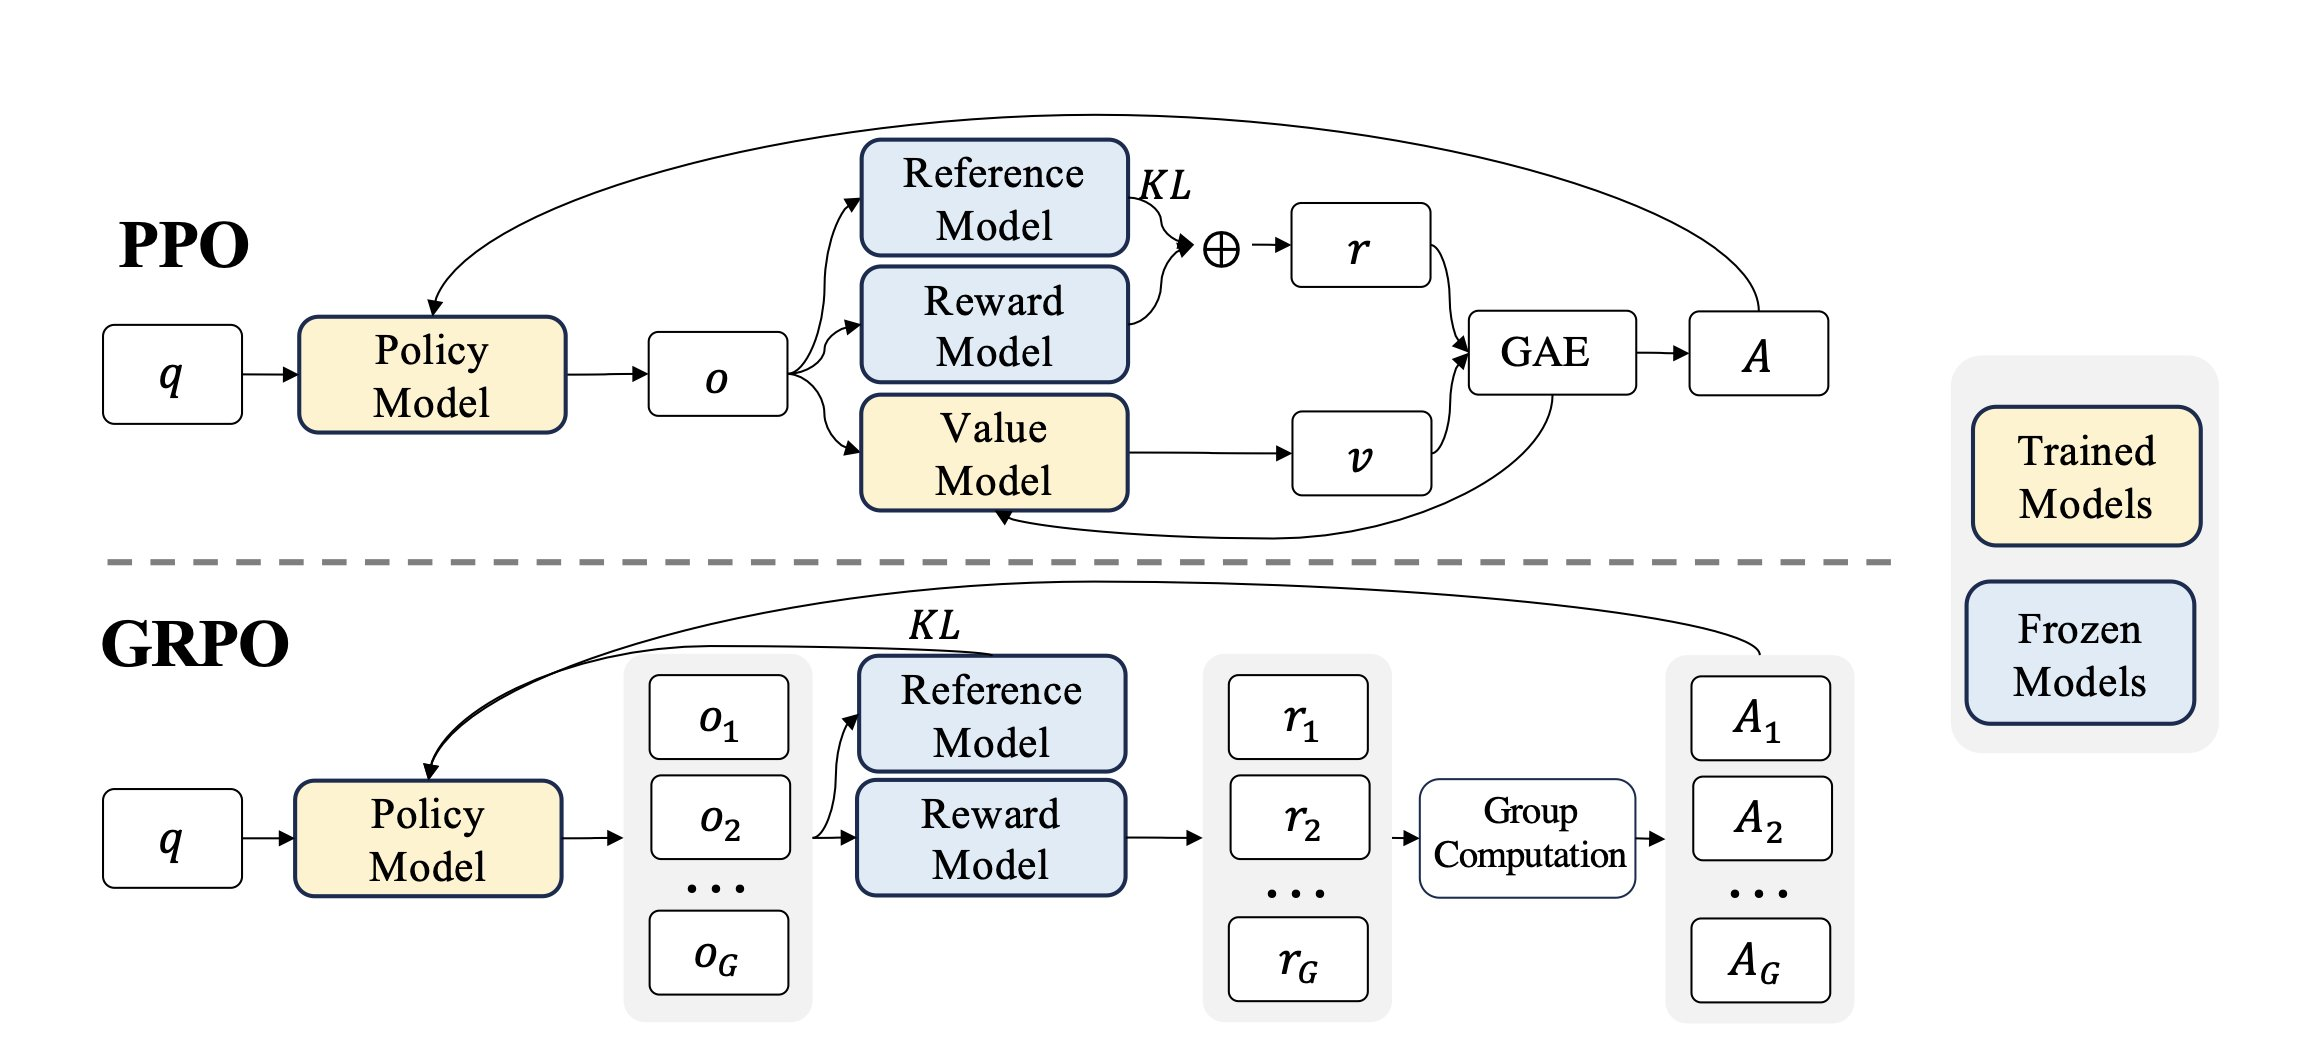

### 3.1 Loading the Baseline Model

To begin, we'll load [Qwen/Qwen2-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2-0.5B-Instruct) as the baseline model (`Policy Model` in the diagram above). With only 0.5 billion parameters, it is lightweight and fits within the available resources. However, for better results, a larger [alternative](https://x.com/jiayi_pirate/status/1882839487417561307) should be considered.  


In [ ]:
import torch
from transformers import AutoModelForCausalLM

model_id = "Qwen/Qwen2-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)

### 3.2 Configuring LoRA

Next, we will configure LoRA for model training. This technique will allow us to efficiently fine-tune the model with a reduced number of parameters, enabling faster and more resource-efficient training.

In [8]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


### 3.3 Loading Reward Functions

For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags. You can find more details [here](https://github.com/huggingface/open-r1/blob/main/src/open_r1/grpo.py). We can simply define and implement these reward functions as generic Python functions.

In this case, we will utilize these reward functions:

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.  

In [9]:
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    rewards_list = [1.0 if match else 0.0 for match in matches]
    return [1.0 if match else 0.0 for match in matches]

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct.

In [10]:
from math_verify import LatexExtractionConfig, parse, verify
def accuracy_reward(completions, **kwargs):
    """Reward function that checks if the completion is the same as the ground truth."""
    solutions = kwargs['solution']
    completion_contents = [completion[0]["content"] for completion in completions]
    rewards = []
    for content, solution in zip(completion_contents, solutions):
        gold_parsed = parse(solution, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        answer_parsed = parse(content, extraction_mode="first_match", extraction_config=[LatexExtractionConfig()])
        if len(gold_parsed) != 0:
            try:
                rewards.append(float(verify(answer_parsed, gold_parsed)))
            except Exception:
                rewards.append(0.0)
        else:
            rewards.append(1.0)
    return rewards

### 3.4 Configuring GRPO Training Parameters

Next, let's configure the training parameters for GRPO. We recommend experimenting with the `max_completion_length`, `num_generations`, and `max_prompt_length` parameters (refer to the image at the beginning for details about each of them).

To keep things simple, we’ll start by training for just one epoch and reducing the `max_completion_length`, `num_generations`, and `max_prompt_length` from their default values.

In [15]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir="Qwen2-0.5B-GRPO-test",
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    gradient_accumulation_steps=16,
    num_train_epochs=1,
    bf16=True,

    # Parameters that control de data preprocessing
    max_completion_length=64, # default: 256
    num_generations=4, # default: 8
    max_prompt_length=128, # default: 512

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
)

### 3.5 Training the Model 🏃

Now, let's configure the trainer and start training the model!

In this case, we pass the two reward functions we previously defined to the trainer

Below, you'll find a diagram of the training procedure we'll be reproducing, which is sourced from the [Open-R1 project](https://github.com/huggingface/open-r1).

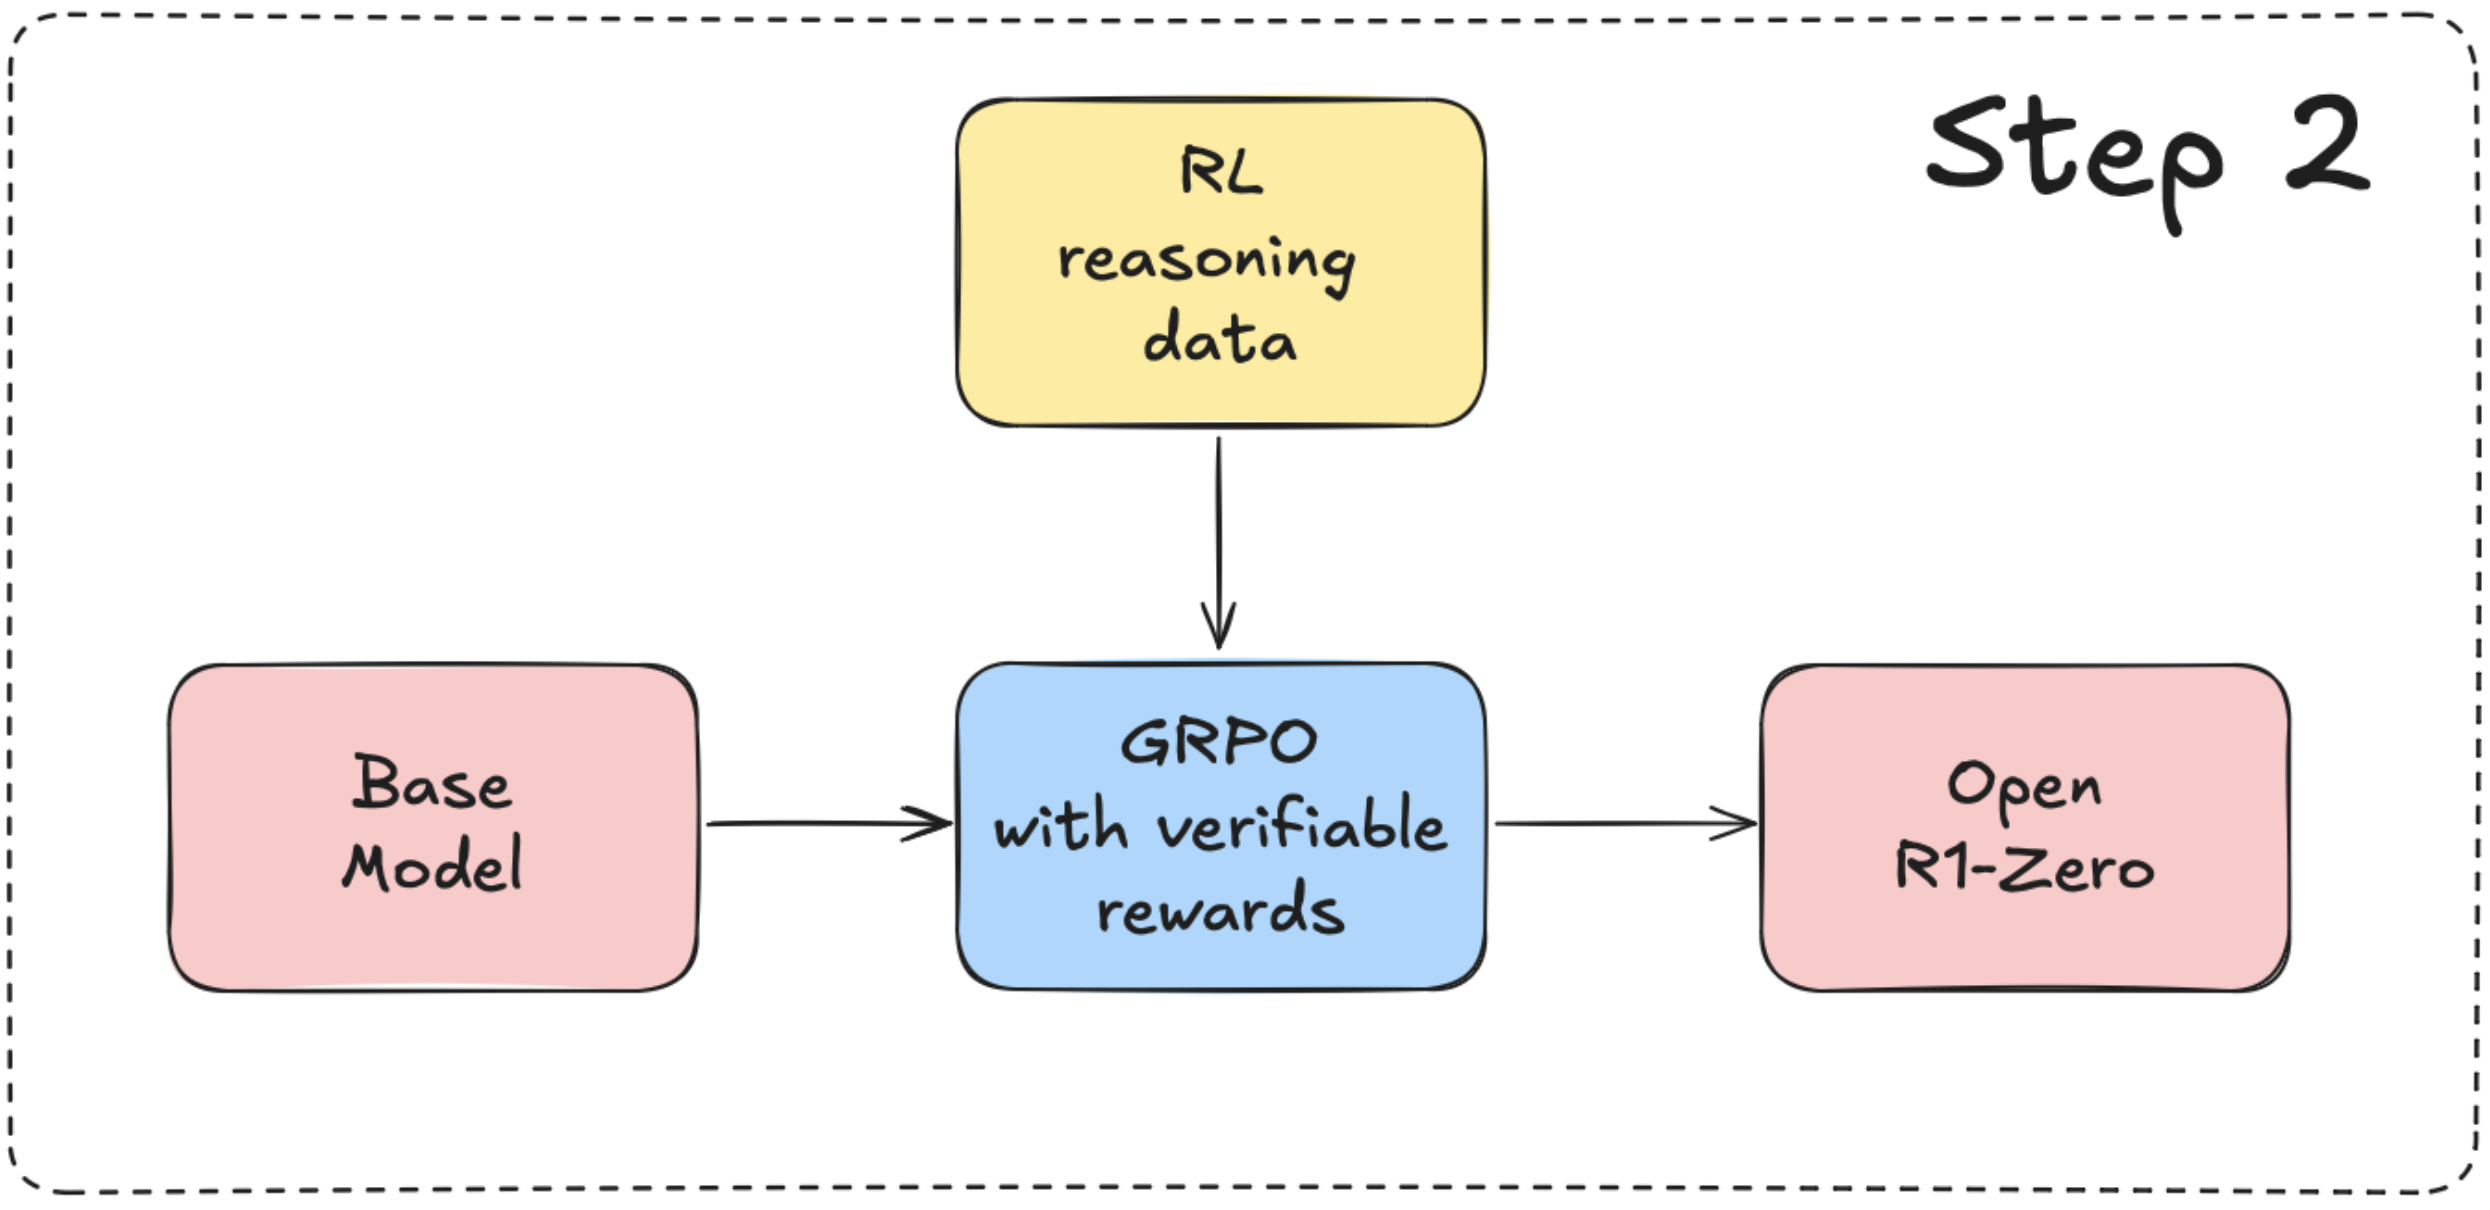

In [16]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    reward_funcs=[format_reward, accuracy_reward],
    args=training_args,
    train_dataset=train_dataset
)

Time to train the model! 🎉

In [ ]:
trainer.train()

Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)
trainer.push_to_hub(dataset_name=dataset_id)

Below, you can review the Tensorboard results for the training. They look promising!

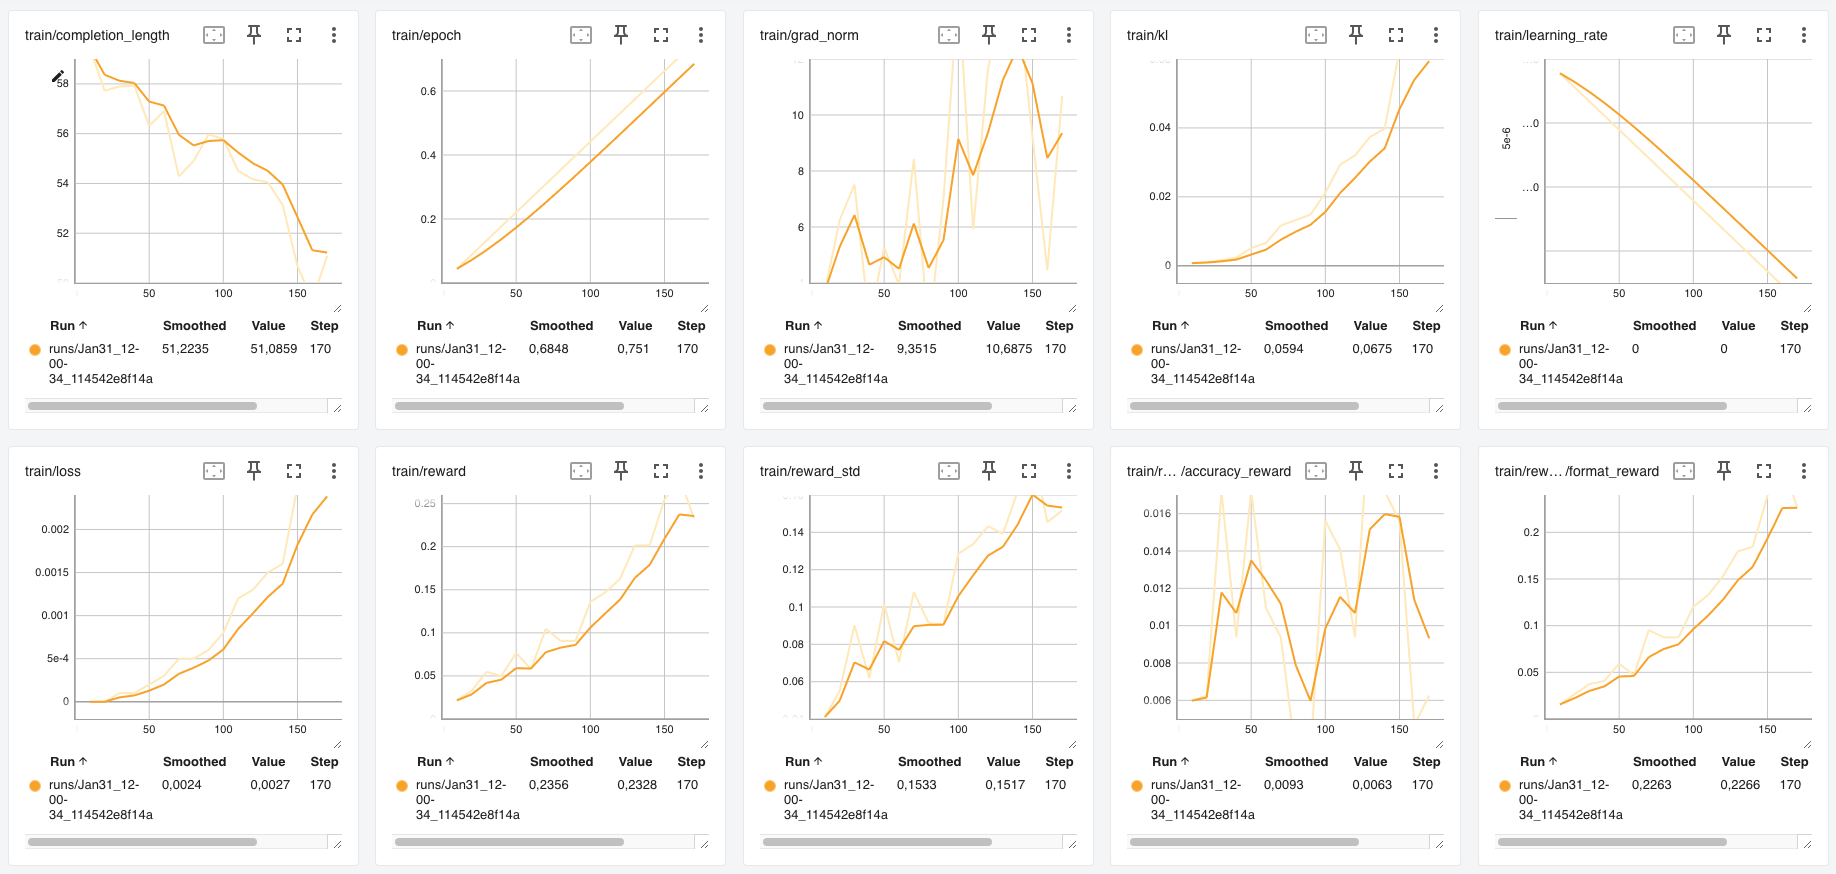

## 4. Check the Model Performance

We've kept things simple so far, but now let's check if the model has already learned to reason. We'll load the saved model and run an evaluation on a test sample.

In [ ]:
from transformers import AutoTokenizer

model_id = "sergiopaniego/Qwen2-0.5B-GRPO"
trained_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's check one sample from the test set!

In [12]:
print(test_dataset['prompt'][0])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>', 'role': 'system'}, {'content': "In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?", 'role': 'user'}]


We'll create a function to interact with the model. In addition to generating the answer, we'll measure the inference duration and count the number of generated tokens. This will give us insights into how much the model has reasoned during generation.

In [13]:
import time

def generate_with_reasoning(prompt):
  # Build the prompt from the dataset
  prompt = " ".join(entry['content'] for entry in prompt)

  # Tokenize and move to the same device as the model
  inputs = trained_tokenizer(prompt, return_tensors="pt").to(trained_model.device)

  # Generate text without gradients
  start_time = time.time()
  with torch.no_grad():
      output_ids = trained_model.generate(**inputs, max_length=500)
  end_time = time.time()

  # Decode and extract model response
  generated_text = trained_tokenizer.decode(output_ids[0], skip_special_tokens=True)

  # Get inference time
  inference_duration = end_time - start_time

  # Get number of generated tokens
  num_input_tokens = inputs['input_ids'].shape[1]
  num_generated_tokens = output_ids.shape[1] - num_input_tokens

  return generated_text, inference_duration, num_generated_tokens

Let's generate the answer for that test sample!

In [17]:
prompt = test_dataset['prompt'][0]
generated_text, inference_duration, num_generated_tokens = generate_with_reasoning(prompt)
print(generated_text)

A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer> In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?<think>
The reasoning process is that if the sum of the digits of the birth year is equal to the person's age, then the person must have been born in a given year.

<think>
The answer is: 1988
</think>


The model already demonstrates the ability to generate the correct `<think>` and `<answer>` tags, even though the solution itself is incorrect.

Given the inference time and the number of generated tokens, this approach shows potential benefits:

In [18]:
print(f"Inference time: {inference_duration:.2f} seconds")
print(f"Generated tokens: {num_generated_tokens}")

Inference time: 2.09 seconds
Generated tokens: 55


Let’s review the generated response to better visualize this behavior:

In [19]:
prompt_text = " ".join(entry['content'] for entry in prompt)
response_text = generated_text[len(prompt_text):].strip()
print(response_text)

<think>
The reasoning process is that if the sum of the digits of the birth year is equal to the person's age, then the person must have been born in a given year.

<think>
The answer is: 1988
</think>


We observe that the model demonstrates some reasoning capabilities, although these are limited. This can be attributed to several factors: the use of a small model, a limited subset of the dataset, and a short training duration to keep the process simple and practical for a notebook environment.

Additionally, the complexity of the dataset plays a role. Simplifying the problem might yield better results, as demonstrated [here](https://www.philschmid.de/mini-deepseek-r1).

Despite these constraints, this technique shows great promise. The release of DeepSeek-R1 and the adoption of this training approach could lead to significant breakthroughs in the coming months!

## 5. Continuing Your Learning Journey 🧑‍🎓

As you can see, this is just the beginning of exploring the GRPO trainer and the DeepSeek R1 model. If you’re eager to dive deeper, be sure to explore the following resources linked in the notebook, as well as these additional materials:

* [DeepSeek-R1's repo](https://github.com/deepseek-ai/DeepSeek-R1/)
* [DeepSeek-R1's paper](https://github.com/deepseek-ai/DeepSeek-R1/blob/main/DeepSeek_R1.pdf)
* [Open reproduction of DeepSeek-R1](https://github.com/huggingface/open-r1/)
* [GRPO TRL trainer](https://huggingface.co/docs/trl/main/en/grpo_trainer)
* [Phil Schmid’s DeepSeek-R1 Blog Post](https://www.philschmid.de/deepseek-r1)
* [Phil Schmid’s mini DeepSeek-R1 Blog Post](https://www.philschmid.de/mini-deepseek-r1)
* [Illustrated DeepSeek-R1](https://newsletter.languagemodels.co/p/the-illustrated-deepseek-r1)
* [The LM Book’s DeepSeek-R1 Article](https://thelmbook.com/articles/#!./DeepSeek-R1.md)

Happy learning and experimenting! 🚀


